In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
%cd drive/My\ Drive/KD100

[Errno 2] No such file or directory: 'drive/My Drive/KD100'
/content/drive/My Drive/KD100


## Discover the data



In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [0]:
#!pip install pygame

In [0]:
import sys
from zipfile import ZipFile
from PIL import Image # $ pip install pillow

filename = 'intel-image-classification.zip'
f=['seg_train','seg_test','seg_pred']
l=['buidings','forest','glacier','sea','street']


def open_image(label,folder,num):
  with ZipFile(filename) as archive:
      with archive.open('{}/{}/{}/{}.jpg'.format(folder,folder,label,num)) as file:
        img = Image.open(file)
  return np.array(img)




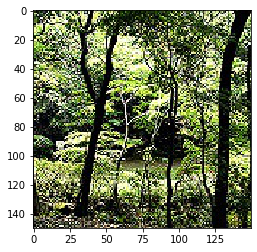

In [54]:
img=open_image('forest','seg_test','20082')
plt.imshow(img)

In [0]:
img_shape=img.shape

In [56]:
img_shape

(150, 150, 3)

In [0]:
def get_all_dir():
  with ZipFile(filename) as archive:
    ls=archive.namelist()
  return ls

dir_ls=get_all_dir()
#len(ls)

**all the data name as panda datafreame**

In [58]:
dir_ls[0],dir_ls[-1]

('seg_pred/seg_pred/10004.jpg', 'seg_train/seg_train/street/999.jpg')

In [59]:
dir_ls[-1].split('/')[0]

'seg_train'

In [60]:
f

['seg_train', 'seg_test', 'seg_pred']

In [0]:
trian_data_name=[]
trian_data_label=[]

test_data_name=[]
test_data_label=[]

pred_data_name=[]

for i in dir_ls:
  s=i.split('/')
  if s[0]==f[0]:
    trian_data_name.append(int(s[-1].split('.')[0]))  #convet it to int going to help with sorting values
    trian_data_label.append(s[-2])
  elif s[0]==f[1]:
    test_data_name.append(int(s[-1].split('.')[0]))
    test_data_label.append(s[-2])
  elif s[0]==f[2]:
    pred_data_name.append(int(s[-1].split('.')[0]))


In [62]:
set(trian_data_label) , len(trian_data_label)

({'buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'}, 14034)

In [63]:
len(pred_data_name) , len(trian_data_label),len(test_data_name)

(7301, 14034, 3000)

In [0]:
train_df=pd.DataFrame(data={'X':trian_data_name,'Y':trian_data_label})
test_df=pd.DataFrame(data={'X':test_data_name,'Y':test_data_label})

In [65]:
train_df.head()

,X,Y
0,0,buildings
1,10006,buildings
2,1001,buildings
3,10014,buildings
4,10018,buildings


In [66]:
test_df.head()

,X,Y
0,20057,buildings
1,20060,buildings
2,20061,buildings
3,20064,buildings
4,20073,buildings


**Make it random by sorting the values of X**

In [67]:
train_df.sort_values(by=['X'],inplace=True)
test_df.sort_values(by=['Y'],inplace=True)

train_df.head()

,X,Y
0,0,buildings
9378,1,sea
13018,2,street
1488,4,buildings
11296,7,sea


In [68]:
print(train_df.iloc[1])

X      1
Y    sea
Name: 9378, dtype: object


**So i have problem now , if i want to convert it to one hot encoding . becuse test and train labels going to have diffrient labels maybe**

*convert it to onehotencoding by func*

In [0]:
labels_uni=list(set(trian_data_label))
def onehot(name):
  arr=np.zeros(len(labels_uni))
  i=labels_uni.index(name)
  arr[i]=1
  return arr

*mmmmm...*

In [70]:
onehot(labels_uni[5])

array([0., 0., 0., 0., 0., 1.])

In [71]:
train_df.shape

(14034, 2)

In [72]:
train_df['Y'].iloc[0]

'buildings'

In [0]:
dim0,dim1,dim2=img_shape
def next_batch(batch_size,itr,t):
  
  if t=='train':
    data=train_df
    folder='seg_train'

  elif t=='test':
    data=test_df
    folder='seg_test'

  l=data.shape[0]
  b_val=(itr*batch_size)%l
  
  x=np.zeros((batch_size,dim0,dim1,dim2))
  y=np.zeros((batch_size,len(labels_uni)))
   
  for i in range(batch_size):
    v=b_val+i
    temp=open_image(data['Y'].iloc[v],folder,str(data['X'].iloc[v]))
    if temp.shape[0]==150 and temp.shape[1]==150:
      x[i]=open_image(data['Y'].iloc[v],folder,str(data['X'].iloc[v]))
      y[i]=onehot(data['Y'].iloc[v])

  
  return x,y


In [0]:
import tensorflow as tf

In [0]:
X=tf.placeholder(tf.float32,shape=[None,150,150,3])
Y=tf.placeholder(tf.float32,shape=[None,6])

In [0]:
hold_prob = tf.placeholder(tf.float32)

In [0]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [0]:
convo_1 = convolutional_layer(X,shape=[20,20,3,32])
convo_1_pooling = max_pool_2by2(convo_1)

convo_2 = convolutional_layer(convo_1_pooling,shape=[20,20,32,64])
convo_2_pooling = max_pool_2by2(convo_2)


convo_2_flat = tf.reshape(convo_2_pooling,[-1,38*38*64])

full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)
y_pred = normal_full_layer(full_one_dropout,6)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y,logits=y_pred))

optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)


In [0]:

init = tf.global_variables_initializer()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.95)

In [0]:
#xx,yy=next_batch(10,0,'train')

In [0]:
saver = tf.train.Saver()

In [0]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

In [87]:
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())
    print('-----------------------------------------------------------')

    for i in range(2000):
        print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++',i)
        batch = next_batch(50,i,'train')
        sess.run(train, feed_dict={X: batch[0], Y: batch[1], hold_prob: 0.5})
        
        
        # # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%20 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(Y,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))
            batch_test = next_batch(500,0,'test')
            print(sess.run(acc,feed_dict={X:batch_test[0],Y:batch_test[1],hold_prob:1.0}))
            print('\n')
    saver.save(sess, "./intel_model")

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

-----------------------------------------------------------
++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 0
Currently on step 0
Accuracy is:
0.0


++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 1
++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 2
++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 3
++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 4
++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 5
++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 6
++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 7
++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 8
++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 9
+++++++

KeyboardInterrupt: ignored